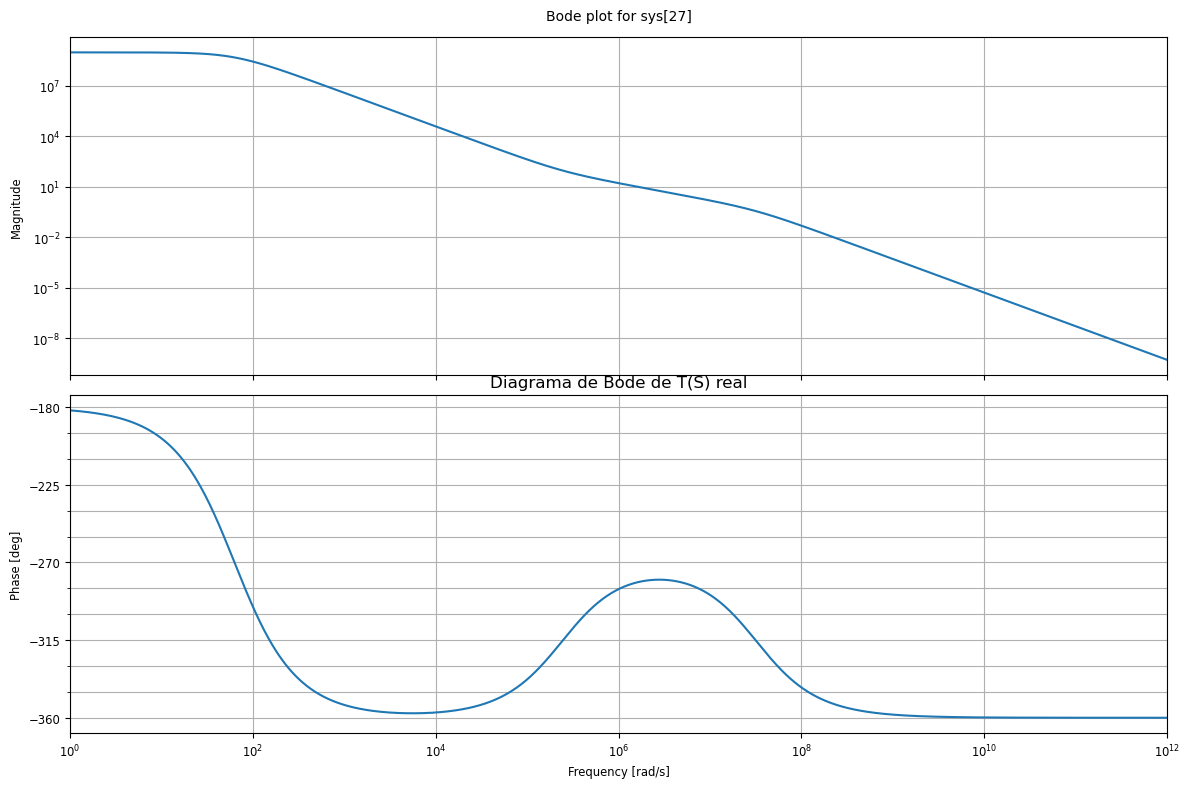

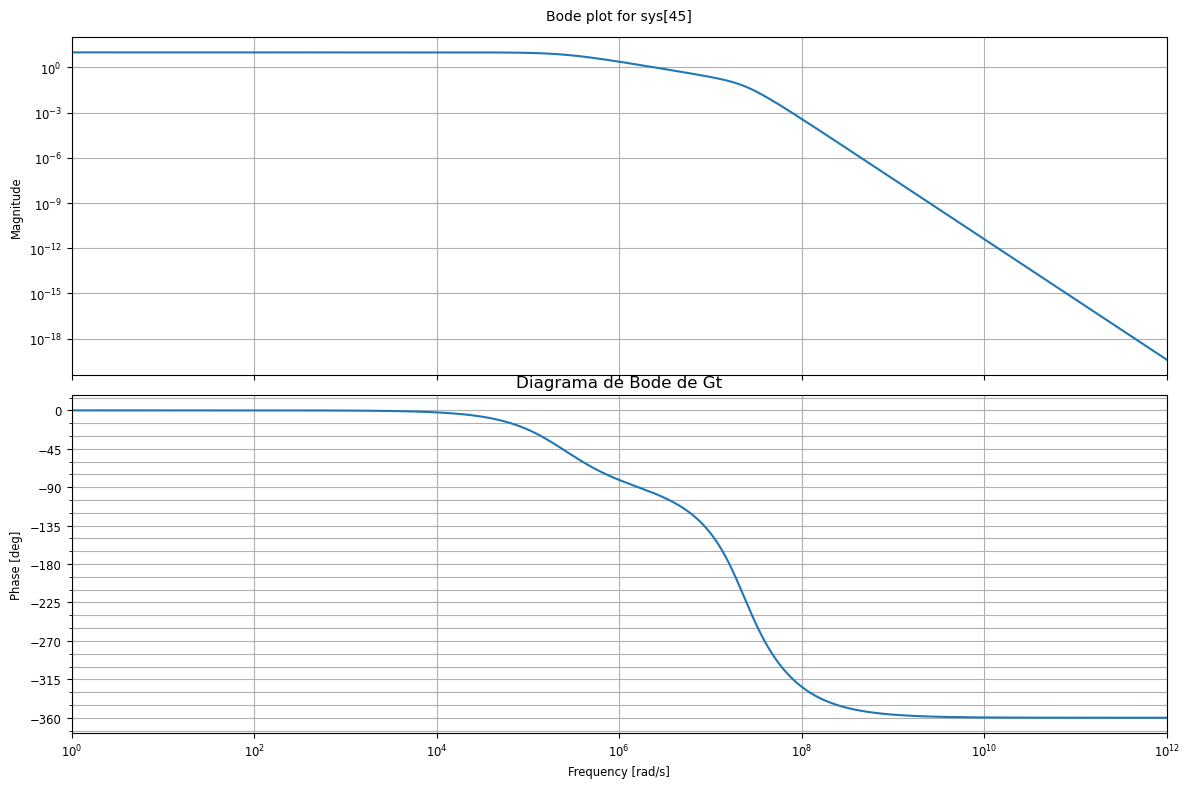

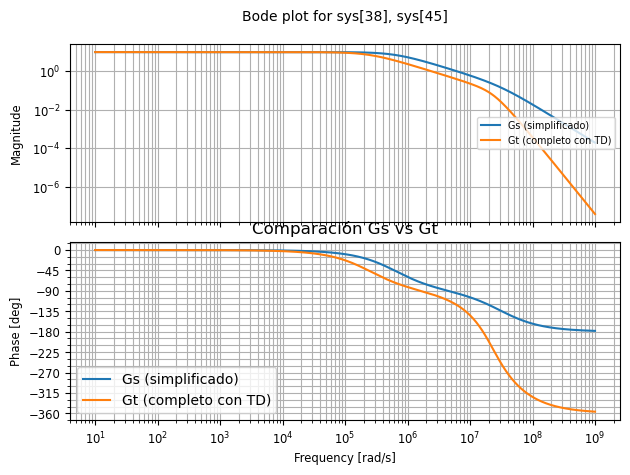

El ancho de banda potencial es:     13.3 Mrad/s
La fase en la frecuencia wg es:     66.3 grados
La frecuencia del polo wp se encuentra en: 20.7 Mrad/s
La frecuencia de wh se encuentra también donde está wp
El ancho de banda a 3dB es desde 0 rad/s hasta 241.1 krad/s


In [1]:
%pip install control numpy matplotlib
import numpy as np
import matplotlib.pyplot as plt
from control import tf, bode_plot, dcgain, mag2db, frequency_response, impulse_response
from control import step_response, impulse_response

# -------------------------------------------------------------------------

# Definición de 's'
s = tf('s')

# Parámetros
k    = 0.1
kpA  = 0
kpB  = 1
kpC  = 10
kpD  = 2.6    # Ganador

# Amplificador operacional abierto (Ao)
# Ao = 100000 / ((1 + s/(2*pi*10)) * (1 + s/(2*pi*5060000)))
pole1 = 2 * np.pi * 10
pole2 = 2 * np.pi * 5_060_000
Ao = 100000 / ((1 + s/pole1) * (1 + s/pole2))

# Términos de realimentación
T1   = -k * Ao**2
T2A  = -kpA * Ao
T2B  = -kpB * Ao
T2C  = -kpC * Ao
T2D  = -kpD * Ao     # Ganador

TA = T1 + T2A
TB = T1 + T2B
TC = T1 + T2C
TD = T1 + T2D        # Ganador

# Modelos simplificados / aproximados
P  = Ao / (1 + Ao/25)               # intento de compensar ignorando polos altos
Ts = -k * Ao                        # realimentación simplificada sin compensar
Gs = Ao / (1 - Ts)                  # modelo simplificado sin compensar

# Modelo "exacto" considerando compensación
Gt = Ao**2 / (1 - TD)               # considerando todo


plt.figure(figsize=(12, 8))
bode_plot(TD, omega_limits=[1e0, 1e12], label='TD')
plt.grid(True)
plt.title('Diagrama de Bode de T(S) real')
plt.show()

plt.figure(figsize=(12, 8))
bode_plot(Gt, omega_limits=[1e0, 1e12], label='Gt')
plt.grid(True)
plt.title('Diagrama de Bode de Gt')
plt.show()


# Comparación de diagramas de Bode

plt.figure()
bode_plot(Gs, label='Gs (simplificado)')
bode_plot(Gt, label='Gt (completo con TD)')
plt.grid(True)
plt.legend()
plt.title('Comparación Gs vs Gt')
plt.show()

# Cálculo de wg: frecuencia donde |TD| ≈ 0 dB
frecuencias1 = np.logspace(np.log10(8e6), np.log10(8e8), 1000)

response = frequency_response(TD, omega=frecuencias1)


mag1   = np.squeeze(response.magnitude)    # elimina dimensiones de tamaño 1 → queda (Nfrec,)
phase1 = np.squeeze(response.phase)        # ídem
omega1 = response.omega                     # siempre 1D

dB1 = mag2db(mag1)                          # a dB

# Encontrar ≈ 0 dB (≤ 1.001 dB de tolerancia)
idx1 = np.where(dB1 <= 1.001)[0]
if len(idx1) > 0:
    idx1 = idx1[0]
    wg   = omega1[idx1]
    phig = np.degrees(phase1[idx1])        # fase → grados
else:
    wg   = np.nan
    phig = np.nan
    print("No se encontró cruce por 0 dB en el rango buscado")

# ----------------------------------------------------------------------
# Frecuencia de -3 dB de Gt normalizado
dc_Gt = dcgain(Gt)
Gt_norm = Gt / dc_Gt

frecuencias2 = np.logspace(np.log10(7e4), np.log10(3e5), 1000)

response2 = frequency_response(Gt_norm, omega=frecuencias2)

mag2   = np.squeeze(response2.magnitude)
dB2    = mag2db(mag2)

# ≈ -3 dB (tolerancia para encontrar el primer cruce descendente)
idx2 = np.where(dB2 <= -2.9)[0]            # o ajusta a -3.0 si es muy estricto
if len(idx2) > 0:
    idx2 = idx2[0]
    w3dB = response2.omega[idx2]
else:
    w3dB = np.nan
    print("No se encontró el punto -3 dB en el rango")

# Resultados
print(f"El ancho de banda potencial es:     {wg/1e6:.1f} Mrad/s")
print(f"La fase en la frecuencia wg es:     {phig:.1f} grados")
print(f"La frecuencia del polo wp se encuentra en: {wg/0.644/1e6:.1f} Mrad/s")
print("La frecuencia de wh se encuentra también donde está wp")
print(f"El ancho de banda a 3dB es desde 0 rad/s hasta {w3dB/1000:.1f} krad/s")
